# Calibrated Adversarial Learning (Part 2)
## Robustness evaluation

In this second notebook we test the approach for robustness towards network initialisation, mode bias and noise in 5 repetitions of 9 different data configurations. The baseline is the non-regularised adversarially trained network.

In [1]:
import hypertunity as ht
import numpy as np
import torch
from torch import optim

import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

from utils import data, networks

In [2]:
torch.manual_seed(1234)

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


As before, we train the calibration network for a fixed number of iterations for each of the data configurations. We also reuse the tranining code from Part 1 but we adapt it to receive a configuration defining some hyperparameters, which we may change between experiments.

In [4]:
def run_step_cal(xs_t, ys_t, opt_cal, net_cal):
    opt_cal.zero_grad()
    loss = -torch.mean(net_cal.ll(xs_t, ys_t))
    loss.backward()
    opt_cal.step()
    return loss.detach().cpu().numpy()

def train_cal(producer, net_cal, opt_cal, config):
    loss_history = []
    data = producer.produce(config.train.batch_size_cal)
    for i in range(config.train.iters_cal):
        xs, ys = next(data)
        xs_t = torch.as_tensor(xs).to(device)
        ys_t = torch.as_tensor(ys).to(device)
        loss = run_step_cal(xs_t, ys_t, opt_cal, net_cal)
        loss_history.append(loss)
    return loss_history

In [5]:
def run_step_dis(xs, ys, ys_ref, net_dis, opt_dis):
    opt_dis.zero_grad()
    loss_dis = -torch.mean(
        torch.sum(net_dis.ll([xs, ys], torch.ones(len(ys)).to(device)), -1)
        + torch.sum(net_dis.ll([xs, ys_ref], torch.zeros(len(ys_ref)).to(device)), -1)
    )
    loss_dis.backward()
    opt_dis.step()
    return loss_dis.detach().cpu().numpy()

def run_step_ref(xs, ys, ys_cal, net_ref, net_dis, opt_ref, n_samples=1, lambda_cal=0.0):
    opt_ref.zero_grad()
    ys_ref = net_ref([xs, ys_cal], n_samples=n_samples)
    xs_repeated = torch.repeat_interleave(xs, repeats=ys_ref.shape[0] // xs.shape[0], dim=0)
    total_loss = 0
    losses_per_type = []
    if lambda_cal > 0:
        ys_ref_mean = torch.mean(ys_ref.view(-1, n_samples), dim=1, keepdim=True)
        loss_kl = 0.5 * torch.mean((ys_ref_mean - ys_cal) ** 2)
        total_loss += lambda_cal * loss_kl
        losses_per_type.append(loss_kl.detach().cpu().numpy())
    ll_dis = net_dis.ll([xs_repeated, ys_ref], torch.ones(len(ys_ref)).to(device))
    loss_dis = -torch.mean(torch.sum(ll_dis, -1))
    total_loss += loss_dis
    losses_per_type.append(loss_dis.detach().cpu().numpy())
    total_loss.backward()
    opt_ref.step()
    return np.array(losses_per_type)

def eval_nets(producer, net_cal, net_ref):
    data = producer.produce(2000)
    xs, ys = next(data)
    xs_t = torch.as_tensor(xs).to(device)
    with torch.no_grad():
        ys_cal = net_cal(xs_t).detach()
        ys_ref = net_ref([xs_t, ys_cal]).detach()
    ys_ref_ll = producer.ll(xs, ys_ref.cpu().numpy().squeeze())
    avg_ll = np.mean(ys_ref_ll)
    return avg_ll
        
def train_dis_ref(producer, net_cal, net_ref, opt_ref, net_dis, opt_dis, config):
    loss_dis_history = []
    loss_ref_history = []
    ll_ref = []
    loss_dis = np.inf
    loss_ref = np.inf
    ys_ref_progress = []
    data = producer.produce(config.train.batch_size_adv)
    for i in range(config.train.iters_adv):
        xs, ys = next(data)
        xs_t = torch.as_tensor(xs.reshape(-1, 1)).to(device)
        ys_t = torch.as_tensor(ys.reshape(-1, 1)).to(device)
        with torch.no_grad():
            ys_cal = net_cal(xs_t).detach()
            ys_ref = net_ref([xs_t, ys_cal]).detach()
        loss_dis = run_step_dis(xs_t, ys_t, ys_ref, net_dis, opt_dis)
        loss_dis_history.append(loss_dis)
        n_samples = config.model.n_samples_cal if config.model.lambda_cal > 0 else 1
        loss_ref = run_step_ref(
            xs_t, ys_t, ys_cal, net_ref, net_dis, opt_ref, n_samples, config.model.lambda_cal
        )
        loss_ref_history.append(loss_ref)
        if i % 10 == 0:
            avg_ll = eval_nets(producer, net_cal, net_ref)
            ll_ref.append(avg_ll)
    return loss_dis, loss_ref, ll_ref

Next we define a single entry point for an experiment, depending on the configuration only, which we generate later.

In [6]:
def build_and_train(config):
    producer = data.Bifurcation(pi=config.data.pi, sigma=config.data.sigma)
    
    net_cal = networks.MLP([64, 64, 64, 64]).to(device)
    opt_cal = optim.Adam(net_cal.parameters(), lr=1e-4)
    loss_cal = train_cal(producer, net_cal, opt_cal, config)
    
    net_ref = networks.Generator(input_dim=2, n_hidden=[64, 64, 64, 64], noise_dim=1).to(device)
    opt_ref = optim.Adam(net_ref.parameters(), lr=1e-4)
    net_dis = networks.Discriminator(input_dim=2, n_hidden=[64, 64, 64, 64]).to(device)
    opt_dis = optim.Adam(net_dis.parameters(), lr=1e-4)
    loss_dis, loss_ref, ll_ref = train_dis_ref(producer, net_cal, net_ref, opt_ref, net_dis, opt_dis, config)
    metrics = {"ll_ref": ll_ref, "loss_dis": loss_dis, "loss_ref": loss_ref, "loss_cal": loss_cal}
    return net_cal, net_ref, net_dis, metrics

Using the `Domain` object in the hypertunity framework we can easily iterate over all combinations of trainig and data configurations of interest.

In [7]:
configs = ht.Domain({"data": {"pi": {0.5, 0.6, 0.9}, 
                              "sigma": {0.01, 0.02, 0.03}},
                     "model": {"lambda_cal": {0, 1}, "n_samples_cal": {10}},
                     "train": {"batch_size_cal": {1000}, "iters_cal": {1500},
                               "batch_size_adv": {100}, "iters_adv": {5000}}
                    })

N_EXPERIMENTS = len(list(configs))
N_REPS = 5

results = [[] for i in range(N_EXPERIMENTS)]
for i, cfg in tqdm.tqdm(enumerate(configs), total=N_EXPERIMENTS):
    cfg = cfg.as_namedtuple()
    for j in tqdm.tqdm(range(N_REPS), total=N_REPS, leave=False):
        net_cal, net_ref, net_dis, metrics = build_and_train(cfg)
        results[i].append((str(cfg), metrics))

We need some indexing operations to extract the loss curves and prepare for plotting. 

In [8]:
baseline = [r for r in results if "lambda_cal=0" in r[0][0]]
calibrated = [r for r in results if "lambda_cal=1" in r[0][0]]

baseline_ll = np.asarray([[run[1]["ll_ref"] for run in runs] for runs in baseline])
baseline_ll = baseline_ll.reshape(3, 3, N_REPS, -1).transpose(1, 0, 2, 3)

calibrated_ll = np.asarray([[run[1]["ll_ref"] for run in runs] for runs in calibrated])
calibrated_ll = calibrated_ll.reshape(3, 3, N_REPS, -1).transpose(1, 0, 2, 3)

Finally, we visualise the average data log-likelihood of all experiments over the course training. We plot the median and Q1-Q3 quartiles to get a sense of the variance of the runs.

In [9]:
def plot_agg_loss_avg(baseline, calibrated, as_bundle=True):
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    N = baseline.shape[-1]
    ax.grid(True)
    total_experiments = N_EXPERIMENTS // 2 * N_REPS
    median1 = np.median(baseline.reshape(total_experiments, -1), axis=0)
    upper1 = np.quantile(baseline.reshape(total_experiments, -1), 0.75, axis=0)
    lower1 = np.quantile(baseline.reshape(total_experiments, -1), 0.25, axis=0)
    ax.fill_between(np.arange(N), lower1, upper1, facecolor="royalblue", alpha=0.4, 
                          label="iqr (baseline)")
    ax.plot(np.arange(N), median1, "-", 
                   linewidth=1.5, color="navy", label="median (baseline)")
    median2 = np.median(calibrated.reshape(total_experiments, -1), axis=0)
    upper2 = np.quantile(calibrated.reshape(total_experiments, -1), 0.75, axis=0)
    lower2 = np.quantile(calibrated.reshape(total_experiments, -1), 0.25, axis=0)
    ax.fill_between(
        np.arange(N), lower2, upper2, facecolor="coral", alpha=0.6, 
        label="iqr (with calibration)"
    )
    ax.plot(
        np.arange(N), median2, "-", linewidth=1.5, color="maroon", 
        label="median (with calibration)"
    )
    ax.legend(loc="lower right")
    ax.set_ylabel(f"Average data log-likelihood")
    ax.set_xlabel(f"Training iteration")

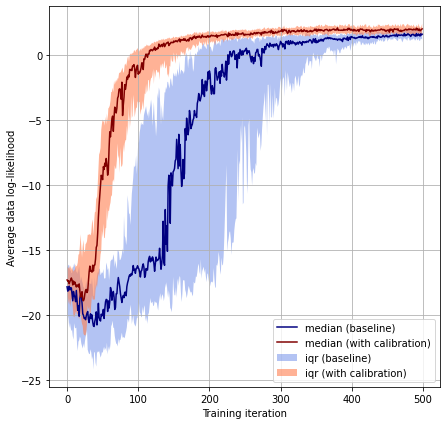

In [10]:
plot_agg_loss_avg(baseline_ll, calibrated_ll, as_bundle=False)

The lower interquartile range and higher median line for the calibrated adversarial approach show that using the calibration target improves stability in training and increases convergence speed.